# Try loading the csv data into Dask dataframes
## Setup
### Importing the required libraries

In [22]:
import dask.dataframe as dd
import dask
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from dask.distributed import Client


### Setup paths

In [2]:
data_folder = Path.cwd().parent / 'data'
transformed_folder = data_folder / 'transformed'
USERS_PATH=Path(transformed_folder,"users.csv")
RATINGS_PATH=Path(transformed_folder,"ratings_filtered_some_set_to_0.csv")
BOOKS_PATH=Path(transformed_folder,"books_final.csv")

## Experiment
### Load the ratings with dask

In [3]:
columns_to_load = ['user_id','book_id','rating']
dtypes = {'user_id': 'int32', 'book_id': 'int32', 'rating': 'float32'}
ratings_dd = dd.read_csv(RATINGS_PATH, usecols=columns_to_load, dtype=dtypes)
ratings_dd=ratings_dd.set_index('user_id')


In [4]:
ratings_dd._meta.dtypes

rating     float32
book_id      int32
dtype: object

In [5]:
ratings_dd.head()

rating  book_id
user_id                 
1           3.0     5556
1           4.0      100
1           4.0      225
1           5.0      102
1           4.0      131

In [6]:
ratings_dd.npartitions

2

In [7]:
ratings_dd.divisions

(1, 24140, 53424)

### Increase partitions
When reducing the data, repartition it to avoid having too many partitions.

In [8]:
ratings_dd=ratings_dd.repartition(partition_size="100MB")
ratings_dd.npartitions

1

In [9]:
ratings_dd.divisions

(1, 53424)

### See the computational graph

In [18]:
columns_to_load = ['user_id','book_id','rating']
dtypes = {'user_id': 'int32', 'book_id': 'int32', 'rating': 'float32'}
ratings_dd = dd.read_csv(RATINGS_PATH, usecols=columns_to_load, dtype=dtypes)
ratings_dd=ratings_dd.set_index('user_id')
ratings_dd.divisions

(1, 24140, 53424)

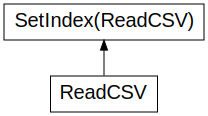

In [19]:
ratings_dd.visualize()

In [12]:
ratings_dd.explain()

In [13]:
rez=ratings_dd.compute()
rez

rating  book_id
user_id                 
1           3.0     5556
1           3.0     3638
1           5.0     1796
1           3.0      867
1           0.0     2738
...         ...      ...
53424       4.0     2068
53424       5.0     4214
53424       4.0     2032
53424       4.0     1369
53424       4.0        1

[3752035 rows x 2 columns]

In [14]:
type(rez)

pandas.core.frame.DataFrame

### Split the ratings by users

In [15]:
all_user_ids = ratings_dd.index.unique().compute().values
all_user_ids

array([    2,     3,     7, ..., 53412, 53413, 53421])

In [16]:
train_user_ids, test_user_ids = train_test_split(all_user_ids, test_size=0.2)


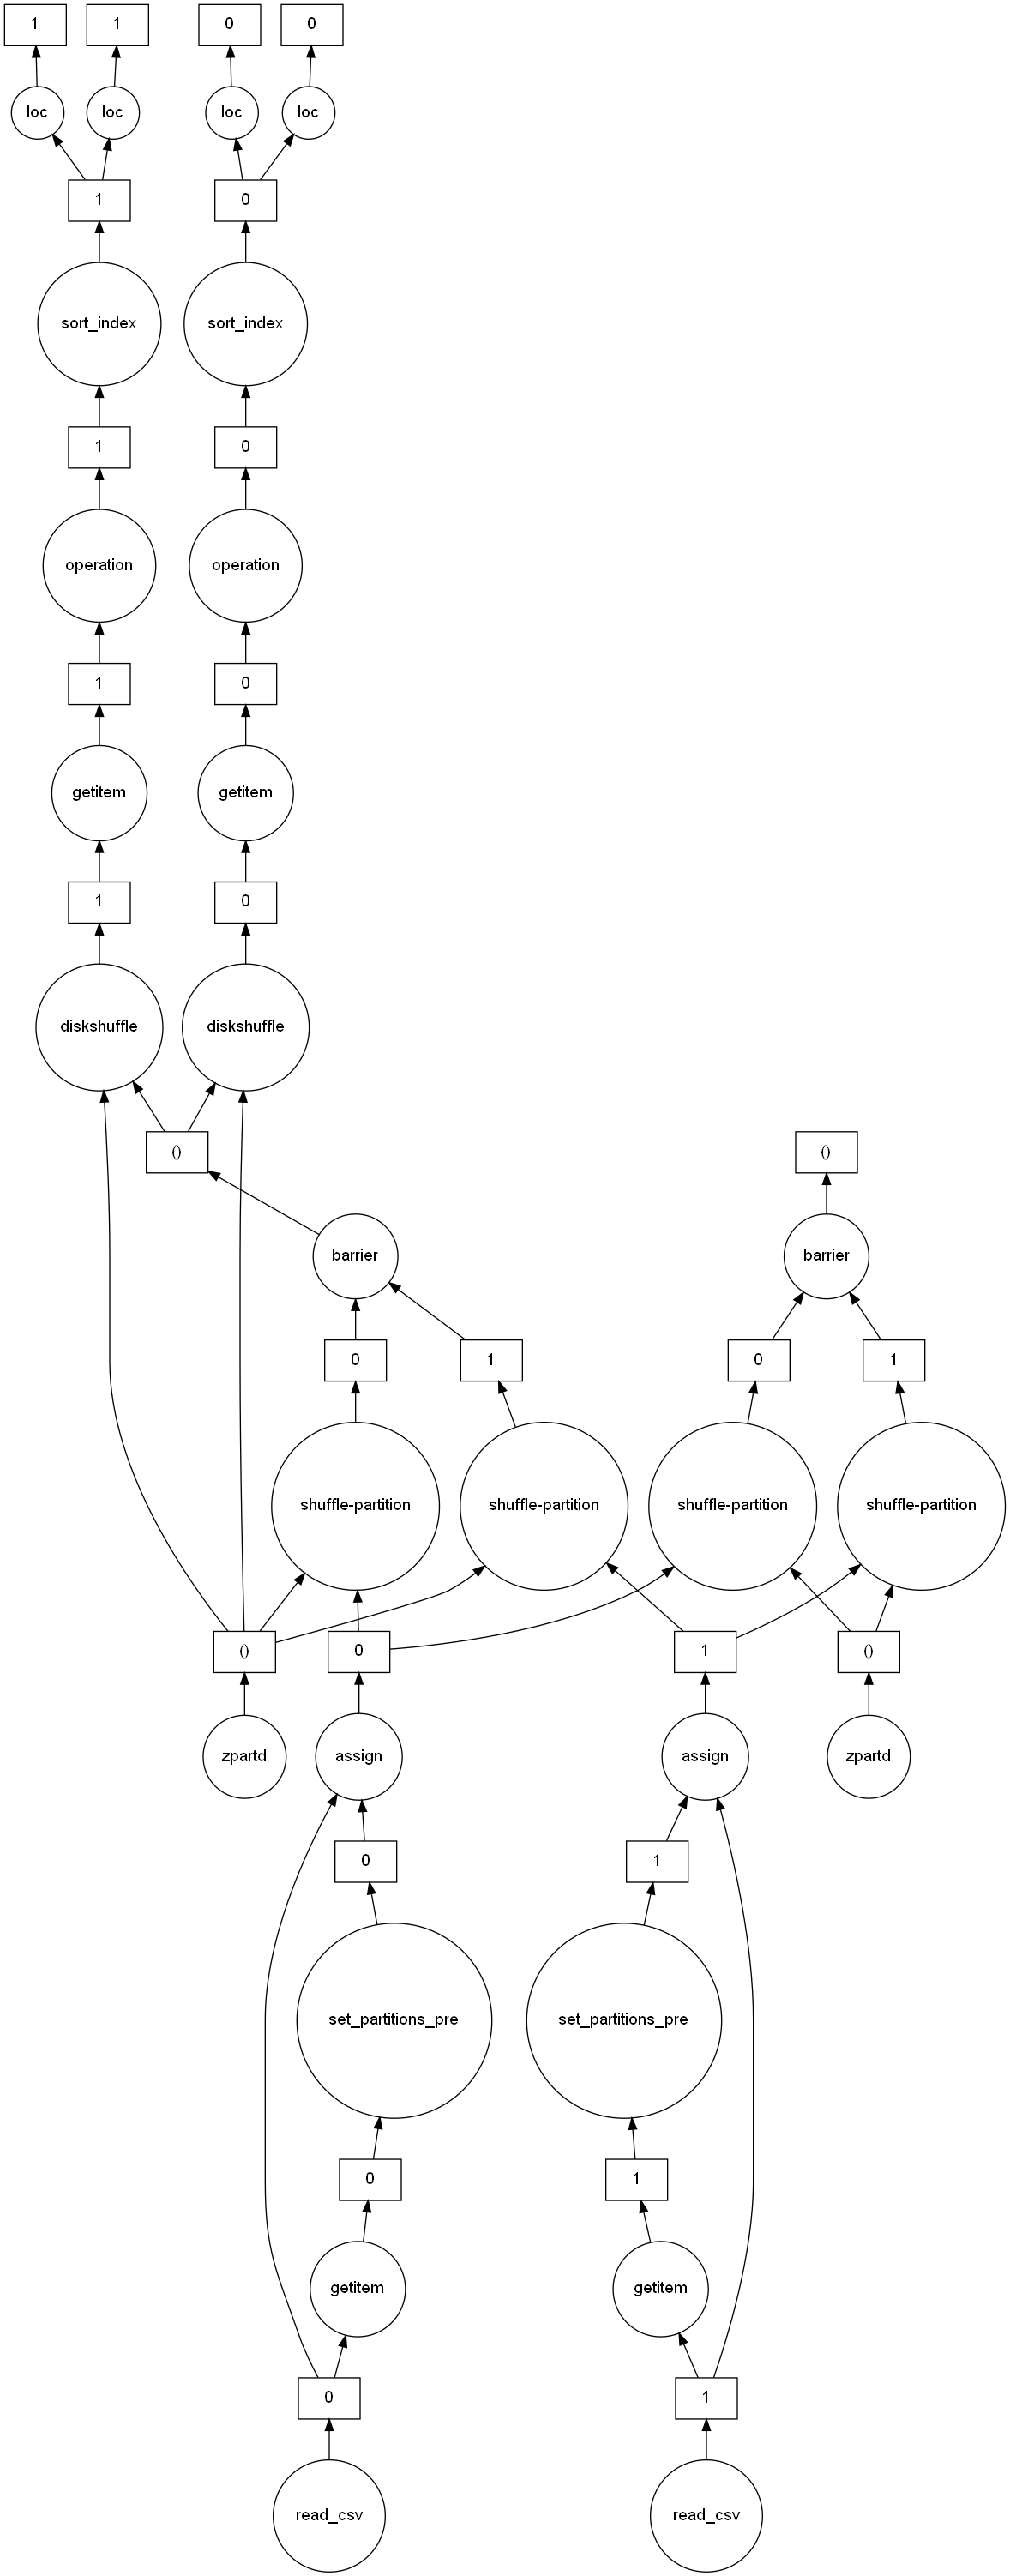

In [17]:
train_data=ratings_dd.loc[train_user_ids]# the user ids selected may be in multiple partitions
test_data_temp=ratings_dd.loc[test_user_ids]
#visualize both graphs complicated graphs, best to use pandas
dask.visualize(train_data,test_data_temp)

### Try persist

In [24]:
client=Client()

c:\Environments\diplomska\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63870 instead
  warnings.warn(


2024-08-26 19:02:44,926 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 924668aeb9be6e9cf30bcd3aee9cafc2 initialized by task ('shuffle-transfer-924668aeb9be6e9cf30bcd3aee9cafc2', 1) executed on worker tcp://127.0.0.1:63891
2024-08-26 19:02:48,299 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 924668aeb9be6e9cf30bcd3aee9cafc2 deactivated due to stimulus 'task-finished-1724691768.297765'


In [25]:
columns_to_load = ['user_id','book_id','rating']
dtypes = {'user_id': 'int32', 'book_id': 'int32', 'rating': 'float32'}
ratings_dd = dd.read_csv(RATINGS_PATH, usecols=columns_to_load, dtype=dtypes)
ratings_dd=ratings_dd.set_index('user_id')
ratings_dd

Dask DataFrame Structure:
                rating book_id
npartitions=2                 
1              float32   int32
24140              ...     ...
53424              ...     ...
Dask Name: setindex, 2 expressions
Expr=SetIndex(frame=ReadCSV(6123220), _other='user_id', options={})

In [26]:

df=client.persist(ratings_dd)
df.dask

{('sort_index-8edb518b245f138954ca15f975f13953',
  0): <Future: pending, key: ('sort_index-8edb518b245f138954ca15f975f13953', 0)>,
 ('sort_index-8edb518b245f138954ca15f975f13953',
  1): <Future: pending, key: ('sort_index-8edb518b245f138954ca15f975f13953', 1)>,
 ('sort_index-4d03ada625bff6f6b271620432a8baa5',
  0): ('sort_index-8edb518b245f138954ca15f975f13953', 0),
 ('sort_index-4d03ada625bff6f6b271620432a8baa5',
  1): ('sort_index-8edb518b245f138954ca15f975f13953', 1)}

In [28]:
df.dask

{('sort_index-8edb518b245f138954ca15f975f13953',
  0): <Future: finished, type: pandas.core.frame.DataFrame, key: ('sort_index-8edb518b245f138954ca15f975f13953', 0)>,
 ('sort_index-8edb518b245f138954ca15f975f13953',
  1): <Future: finished, type: pandas.core.frame.DataFrame, key: ('sort_index-8edb518b245f138954ca15f975f13953', 1)>,
 ('sort_index-4d03ada625bff6f6b271620432a8baa5',
  0): ('sort_index-8edb518b245f138954ca15f975f13953', 0),
 ('sort_index-4d03ada625bff6f6b271620432a8baa5',
  1): ('sort_index-8edb518b245f138954ca15f975f13953', 1)}